In [306]:
import os 
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from tqdm.notebook import tqdm

# import custom functions
os.chdir('..')
from RuckFunctions import DataLoading, Preprocessing, PACS, PacsFeats


Load data

In [2]:
# Initialize path to data (UTM-converted datasets)
data_dir = os.getcwd() + '\\SampleData'

# Load datasets
raw_datasets = DataLoading.load_data(data_dir)

# Re-shape datasets
datasets = DataLoading.pivot_datsets(raw_datasets)

Get the interpolated data

In [3]:
# get interpolated datasets
interp_datasets = Preprocessing.interpolate_datasets(datasets, threshold = 0.99)

Get movement periods


In [4]:
# get slices for movement periods and break times   
rucks_bySquad, rests_bySquad, all_stops = Preprocessing.get_slices_byArea(interp_datasets, plot=False)

Get the smoothed data of one example squad


In [5]:
smooth_rucks = Preprocessing.spline_smoothing(rucks_bySquad[1], s=3e1, UTM=True)

Get a sample slice of data and apply the Path-Adapted Coordinate System (PACS) transformation

In [6]:
# Orient ruck periods
ruck_slices_oriented = PACS.PACS_transform(smooth_rucks)

re-orienting data


100%|██████████| 7/7 [7:57:41<00:00, 4094.48s/it]


Get a names for feature extraction

In [8]:
names = smooth_rucks[0].latitude.columns.tolist()

Spatial Exploration Index (SEI)

In [9]:
SEIs = PacsFeats.get_SEIs(ruck_slices_oriented, names)

100%|██████████| 7/7 [00:00<00:00, 36.52it/s]


Nearest Neighbor (X and Y directions)

In [10]:
x_neighbors, y_neighbors = PacsFeats.get_neighbor_dists(ruck_slices_oriented, names)

Get length/width ratio

In [11]:
LW_ratios = PacsFeats.LW_ratio(ruck_slices_oriented)

Get distribution consistency

In [12]:
X_ftest, Y_ftest = PacsFeats.dist_consistency_Ftest(ruck_slices_oriented, names)
X_wass_df, Y_wass_df = PacsFeats.dist_consistency_wasserstein(ruck_slices_oriented, names)

Plotting

In [262]:
# define colors for all plots 
color_dictionary = dict(zip(names, sns.color_palette(as_cmap=True)[:len(names)]))

In [334]:
# set length of time period to plot
time_length = 100

# # get random time periods
# random_period = np.random.randint(len(ruck_slices_oriented))
# random_timepoint = np.random.randint(len(ruck_slices_oriented[random_period])-time_length)

random_period = 2
# random_timepoint = 1650
random_timepoint = 1500

# get section
random_slice = smooth_rucks[random_period].iloc[random_timepoint:random_timepoint+time_length]
random_PACS_slice = ruck_slices_oriented[random_period].iloc[random_timepoint:random_timepoint+time_length]

#  get a sample path
x_UTM = random_slice[[('UTM_x', n)for n in names]].mean(axis=1)
y_UTM = random_slice[[('UTM_y', n) for n in names]].mean(axis=1)

# Get equivalent PACS coordinates
# make straight line to represent forward movement
x_PACS = pd.Series(0 * np.arange(time_length))
y_PACS = pd.Series(np.arange(time_length))

In [297]:
# random_slice.to_pickle(r'C:\Users\James\Downloads\rndslcs.pkl')
# random_PACS_slice.to_pickle(r'C:\Users\James\Downloads\rndpacsslcs.pkl')

In [298]:
# tick params

# set which tick to make as t=0
# make a ratio of total time period
ztick = time_length//5

# tick parameters
dist_from_line = 10
n_ticks = 2

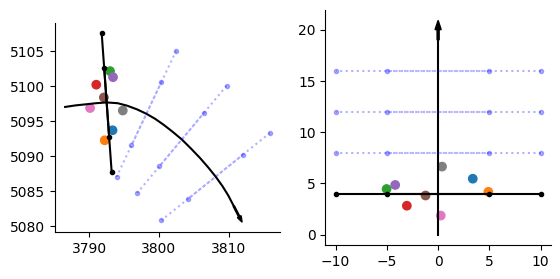

In [329]:
# make plots
fig, axs = plt.subplots(1, 2)

# loop through two plots. UTM and PACS
for x, y, ax, plottype in zip([x_UTM, x_PACS], [y_UTM, y_PACS], axs, ['UTM', 'PACS']):

    # set up curve
    curve_df = pd.DataFrame()
    curve_df['x'] = x
    curve_df['y'] = y

    # get normalized slope for y axis ticks
    curve_diff = curve_df.diff()
    curve_slope = curve_diff['y'] / curve_diff['x']
    norm_slope = -1/curve_slope

    # plot the path
    ax.plot(x, y, color='k')
    ar = ax.arrow(x.iloc[-1], y.iloc[-1],dx=x.diff().iloc[-1], dy=y.diff().iloc[-1], color='k', width=0.2)

    # initialize x and y vals for ticks
    X_vals = []
    Y_vals = []

    # plot every X ticks
    evtick = 4

    # plot ticks
    for count, (this_x, this_y, this_slope) in enumerate(zip(x[::evtick], y[::evtick], norm_slope[::evtick])):
        
        # if slop is na skip
        if math.isnan(this_slope): continue

        # assign m as slope
        m = this_slope

        # loop through steps in path to plot ricks
        for l in np.arange(0, dist_from_line/n_ticks + dist_from_line, dist_from_line/n_ticks)[1:]:

            # ticks here
            dx = (l / math.sqrt(1 + (m * m)))
            dy = m * dx
            Px = this_x + dx
            Py = this_y + dy
            Nx = this_x - dx
            Ny = this_y - dy

            # append ticks
            X_vals = [Px, Nx]
            Y_vals = [Py, Ny]

            # make t=0 a darker tick
            if count == ztick//evtick:
                ax.plot(X_vals, Y_vals, color='k', marker = '.', markevery=1)
            else:
                ax.plot(X_vals, Y_vals, ls=':', color='b', marker = '.', markevery=1, alpha = 0.3)

            ax.set_aspect('equal')

# plot individuals on path at that time 0
axs[0].scatter(random_slice.iloc[int(ztick)][[('UTM_x', n)for n in names]], random_slice.iloc[int(ztick)][[('UTM_y', n)for n in names]], c = [color_dictionary[n] for n in names])

axs[1].scatter(random_PACS_slice.iloc[int(ztick)][[n+' longitude' for n in names]], random_PACS_slice.iloc[int(ztick)][[n+' latitude' for n in names]]+ztick, c = [color_dictionary[n] for n in names])



sns.despine()
plt.show()

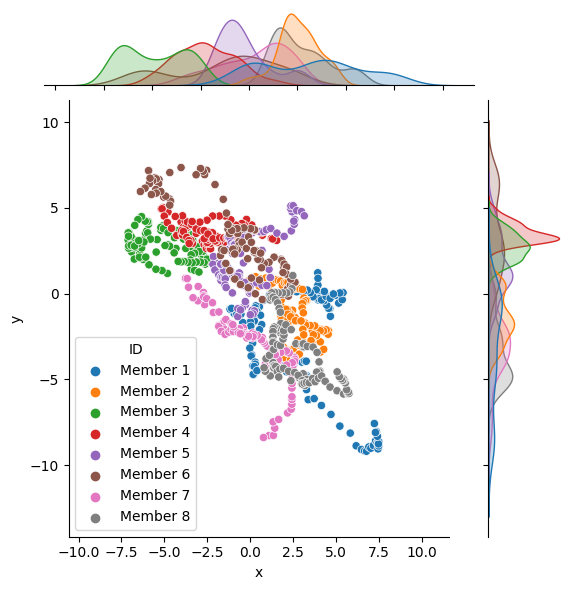

In [335]:
indivs_data = []

for name in names:
    this_person_data = random_PACS_slice[[c for c in random_PACS_slice.columns if name in c]]
    this_person_data.columns = 'x', 'y'
    this_person_data['ID']=name
    indivs_data.append(this_person_data)

data_to_plot = pd.concat(indivs_data)




jointfig = sns.jointplot(data=data_to_plot.reset_index(), x='x', y='y', hue='ID', dropna=True, palette = color_dictionary)
jointfig.ax_joint.set_aspect('equal')

